In [243]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.linear_model import LinearRegression
from operator import itemgetter, attrgetter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist, pdist
plt.style.use("ggplot")
%matplotlib inline
 
import json

In [2]:
MTA_data = np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy").astype(float)

In [3]:
MTA_data[MTA_data == -1] = np.nan

In [4]:
MTA_data.shape

(600, 23, 194)

In [5]:
mtastation = np.nanmean(MTA_data, axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [34]:
daterg = pd.date_range("05/21/2010","02/21/2014", freq="w")

In [36]:
daterg.shape

(196,)

In [8]:
def detection(data):
    meanval = np.nanmean(data)
    stdval = np.nanstd(data)
    threshold = [meanval - 3*stdval, meanval + 3*stdval]
    indx = np.where((data > threshold[1])|(data < threshold[0]))
    return indx, threshold

In [149]:
indx = detection(np.nanmean(mtastation, axis=0))[0][0]
detectdate = daterg[indx+1]

In [48]:
print ("the abnormal date that event happens is {}".format(str(detectdate[0].date())))

the abnormal date that event happens is 2012-10-28


Due to https://en.wikipedia.org/wiki/Hurricane_Sandy landing on the NY, I think most of people stay at home, that's why almost no one take train that day

In [11]:
mtacard = np.nanmean(MTA_data, axis=0)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [14]:
cardmean = np.zeros(mtacard.shape)
for i in range(mtacard.shape[0]):
    cardmean[i,:] = pd.rolling_mean(mtacard[i,:], 10)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


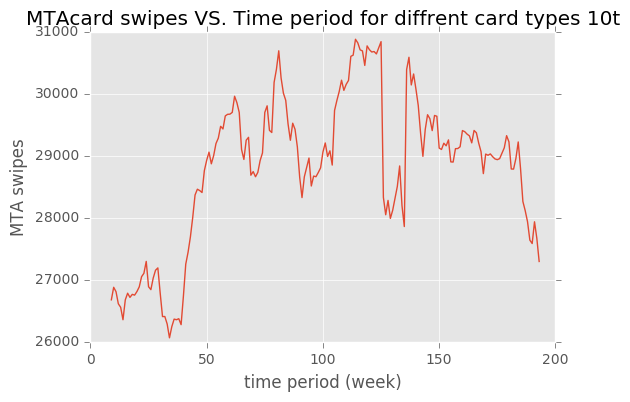

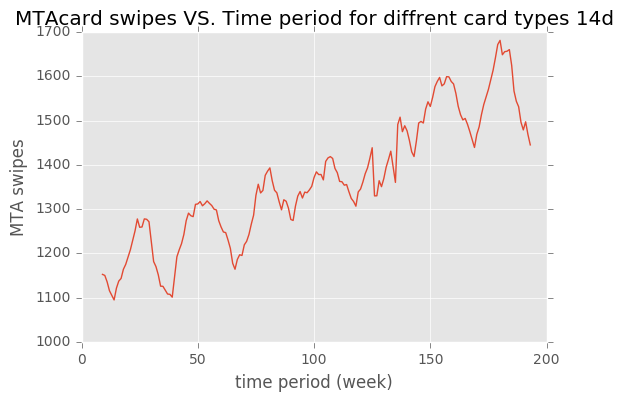

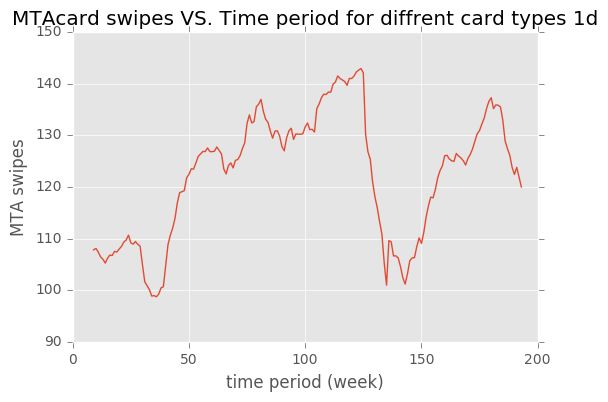

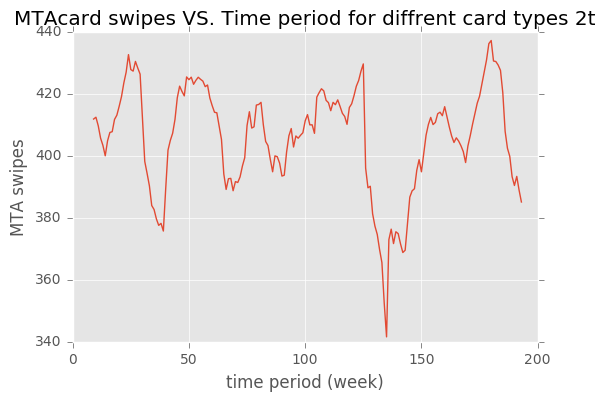

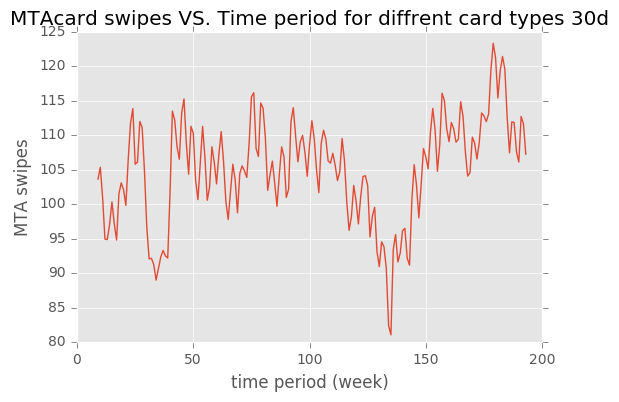

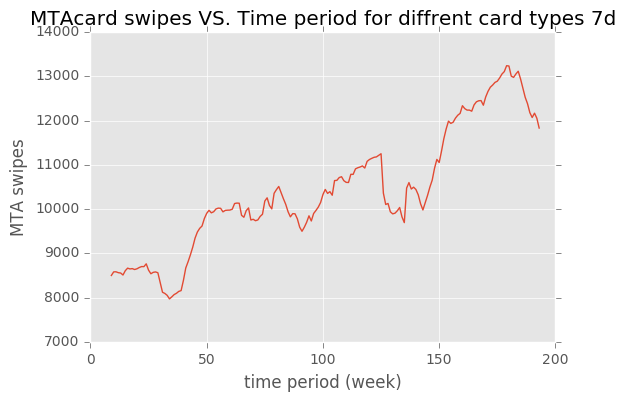

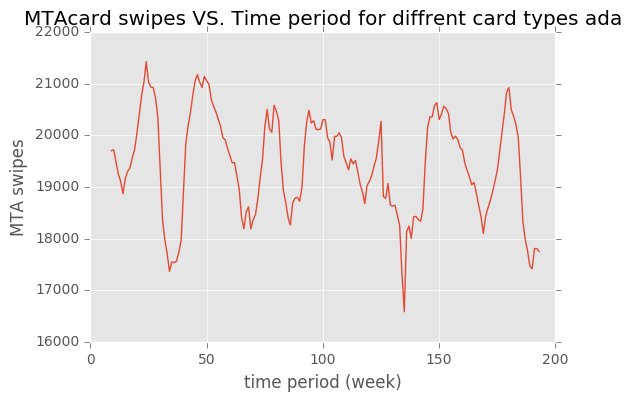

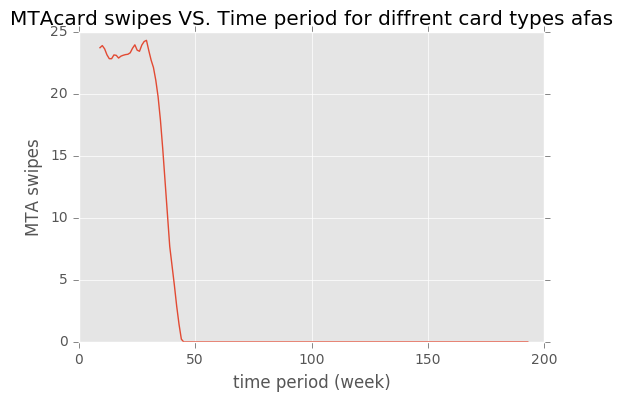

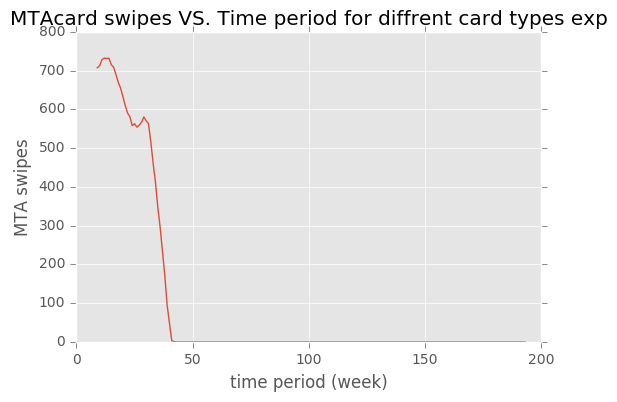

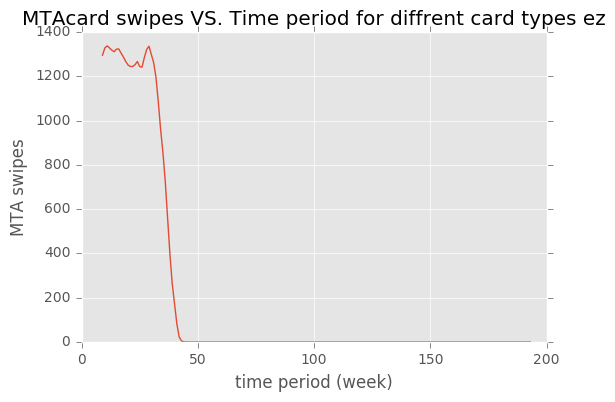

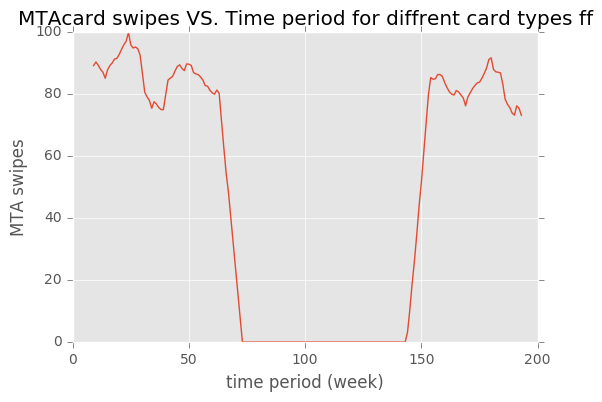

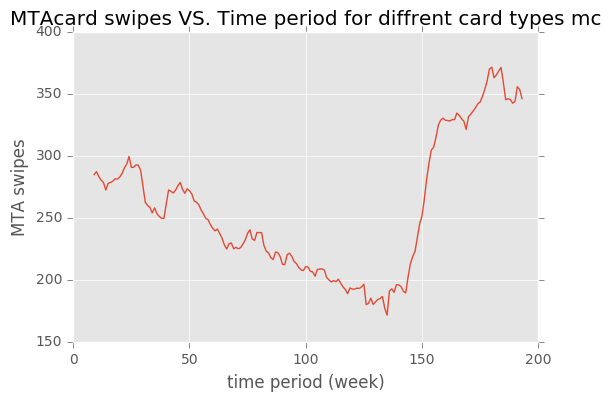

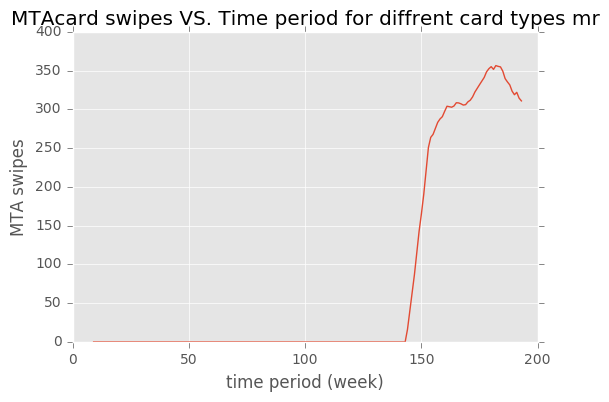

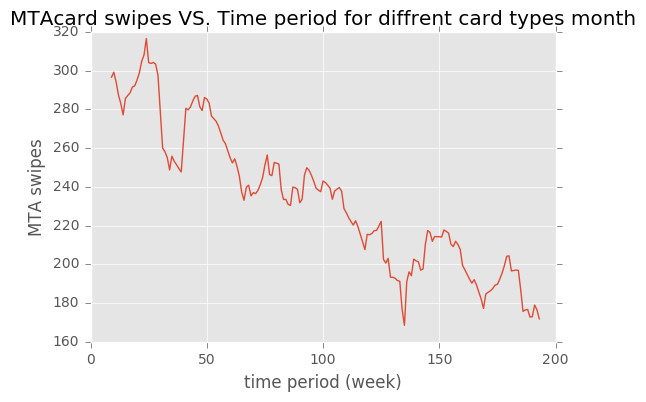

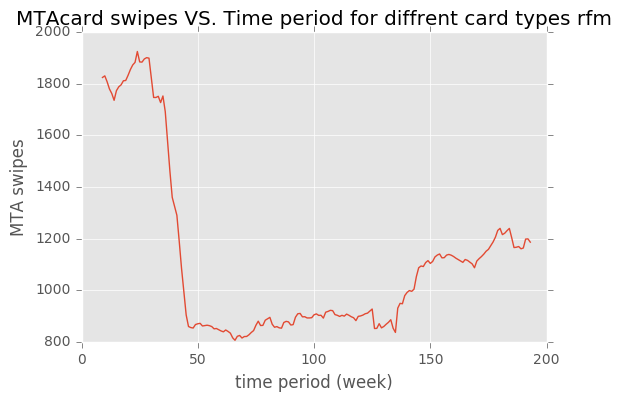

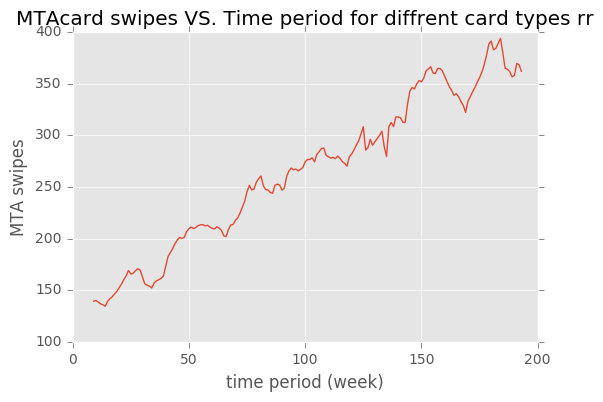

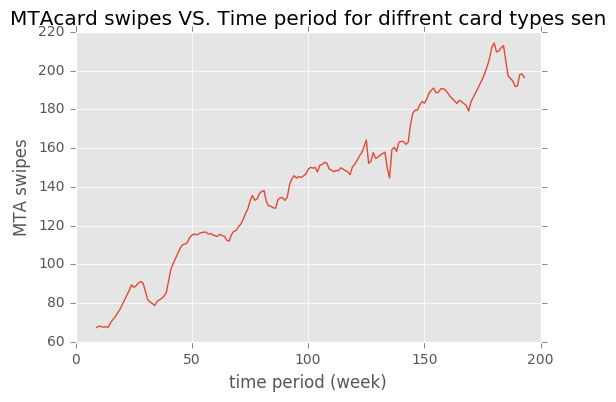

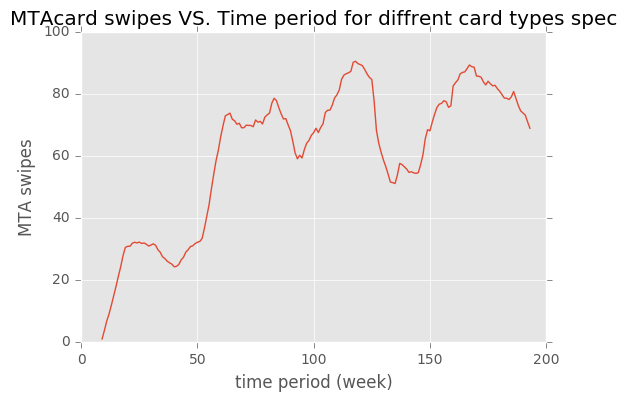

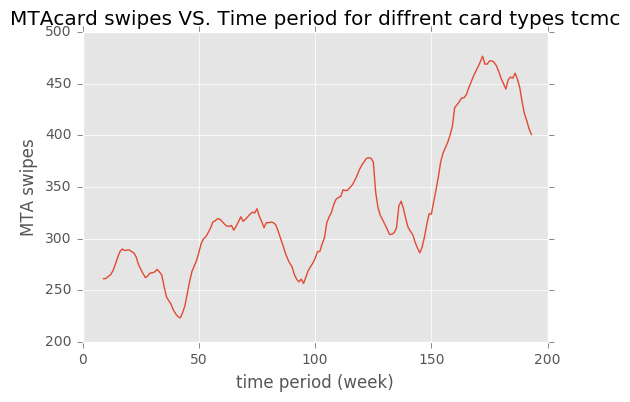

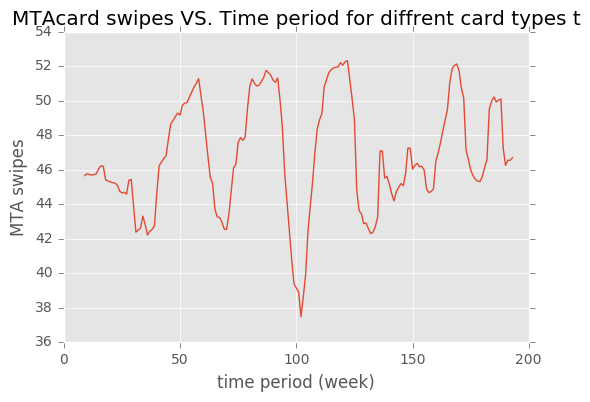

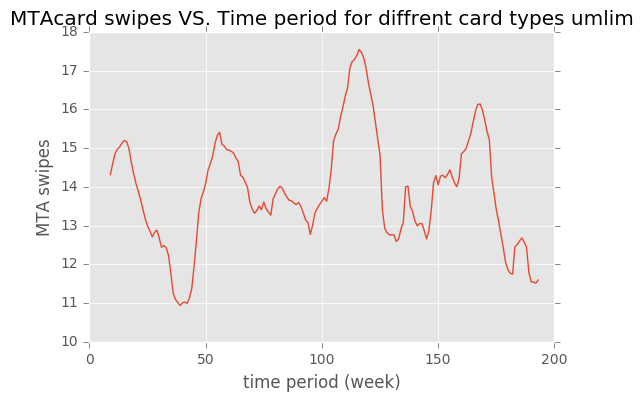

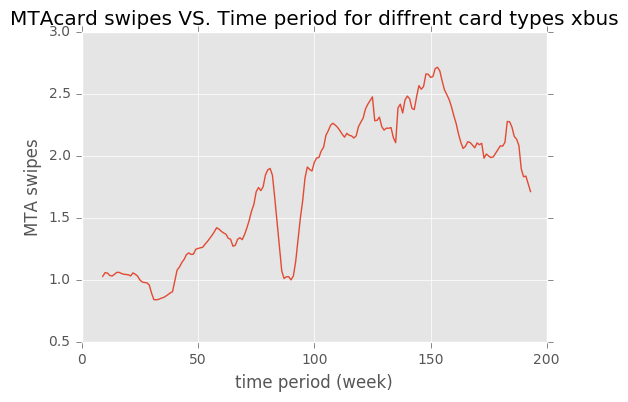

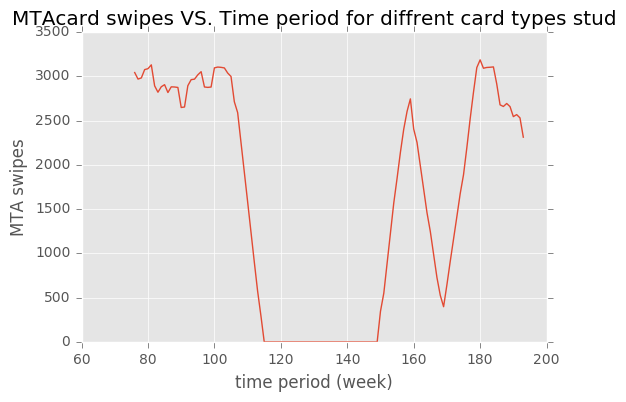

In [39]:
fig = plt.figure(figsize=(10,8))
for i in range(23):
    fig = plt.figure()
    plt.plot(cardmean[i,:])
    plt.legend(loc="upper left")
    plt.title("MTAcard swipes VS. Time period for diffrent card types " + (ridetype[i]))
    plt.xlabel("time period (week)")
    plt.ylabel("MTA swipes")

##### Plot the time period against MTA swipes for different type of cards to visually inspect the trend


##### It's easy to show in the plot that tcmc, sen, xbus, spec, rr, month, 7d, 14d, show a clear trend, among those, except for month type card, others have a increasing trend

In [16]:
trendlist = np.array(["tcmc", "sen", "xbus", "spec", "rr", "month", "7d", "14d"])

In [17]:
for i in range(len(trendlist)):
    trendpos = np.where(ridetype == trendlist[i])[0]
    ratio = np.mean(mtacard[trendpos,:10])/np.mean(mtacard[trendpos,-10:])
    print ("for cardtype {}, the trend ratio is {}".format(trendlist[i], ratio))

for cardtype tcmc, the trend ratio is 0.6517889563631808
for cardtype sen, the trend ratio is 0.3432476551905553
for cardtype xbus, the trend ratio is 0.6007146360487403
for cardtype spec, the trend ratio is 0.014223018219323634
for cardtype rr, the trend ratio is 0.385131221691354
for cardtype month, the trend ratio is 1.7256008144142578
for cardtype 7d, the trend ratio is 0.7185938207202762
for cardtype 14d, the trend ratio is 0.7976242764332595


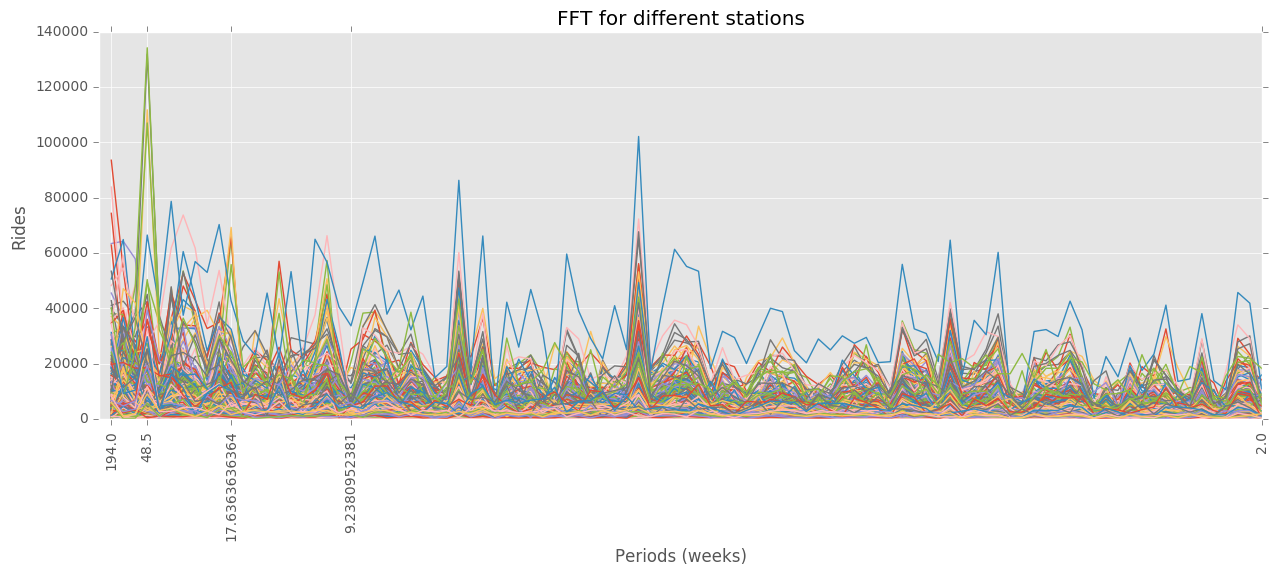

In [67]:
fig=plt.figure(figsize=(15,5))
peak = []
for i in range(len(mtastation)):
    f = np.abs(np.fft.rfft(mtastation[i,:]))[1:]
    ax=fig.add_subplot(111)
    periods = np.fft.rfftfreq(mtastation[i,:].shape[0], 1)[1:]
    peak.append(f[3])
    ax.plot(periods, f)
allperiods = periods[[0, 3, 10, 20, -1]]
ax.set_xticks(allperiods)
ax.set_xticklabels(["%s"%(1/f) for f in allperiods], rotation=90)
ax.set_xlabel("Periods (weeks)")
ax.set_ylabel("Rides")
ax.set_title("FFT for different stations")

##### Plot the FFT result for 600 different stations to look into the data intuitively

In [ ]:
peak = np.array(peak)

In [108]:
sort = np.argsort(peak)[::-1]

In [151]:
mask = np.where(~np.isnan(peak[sort]))[0]
stations = sort[mask][:4]

In [152]:
print ("4 station that show the most prominent periodic trend on an annual period are {}".format(stations))

4 station that show the most prominent periodic trend on an annual period are [194 150  32 327]


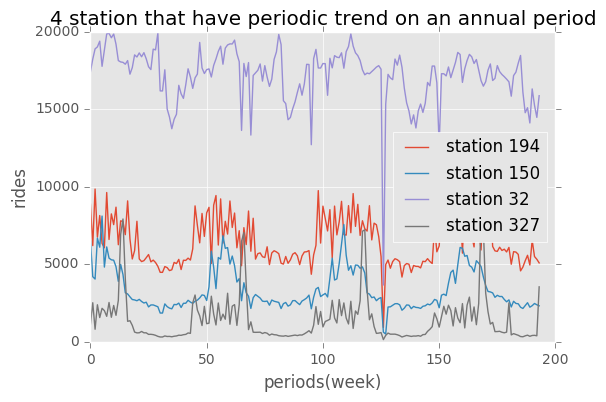

In [155]:
for i in stations:
    plt.plot(mtastation[i], label = "station "+str(i))
plt.title("4 station that have periodic trend on an annual period")
plt.ylabel("rides")
plt.xlabel("periods(week)")
plt.legend(loc = "best")

In [223]:
tots = MTA_data.transpose(2,0,1).reshape(MTA_data.shape[2], MTA_data.shape[1]*MTA_data.shape[0]).T

In [224]:
tots = tots[tots.std(1)>0]

In [225]:
tots_std = (tots - np.nanmean(tots, axis=0)) / np.nanstd(tots, axis=0)

In [241]:
def elbow(data,K):
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xticks(K)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss   
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xticks(K)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

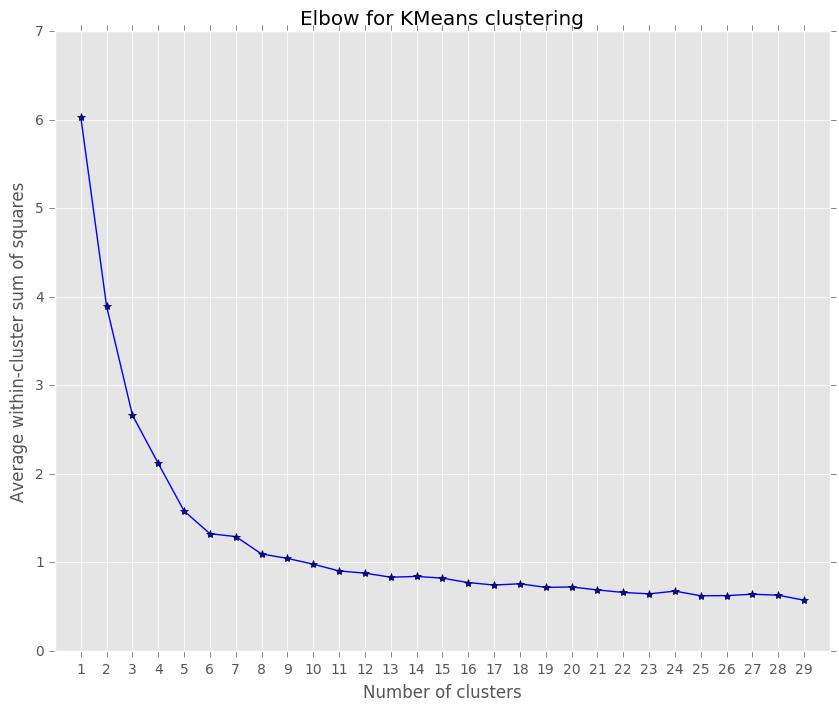

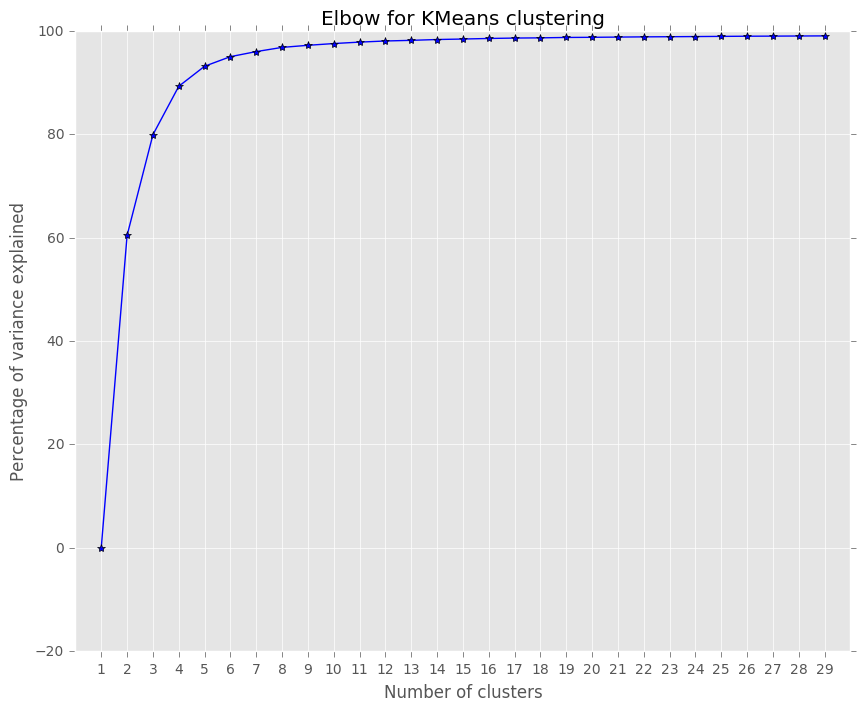

In [244]:
elbow(tots_std, range(1,30))

#### Here by using elbow method we can see that the best number of clusters is 6

In [245]:
km = KMeans(n_clusters=6).fit(tots_std)

In [246]:
cluster_label = km.predict(tots_std)

In [247]:
n = tots_std.shape[1]
pca = PCA(n)
Xproj = pca.fit_transform(tots_std)

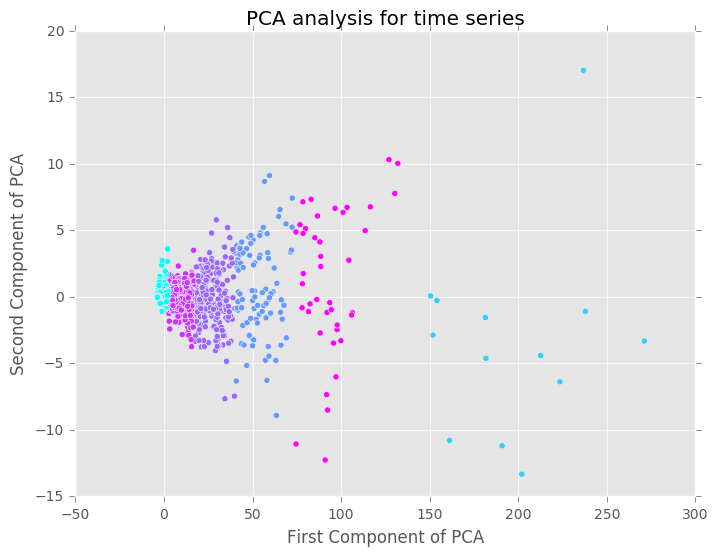

In [248]:
plt.figure(figsize=(8, 6))
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=cluster_label, cmap=plt.cm.cool)
plt.xlabel('First Component of PCA')
plt.ylabel('Second Component of PCA')
plt.title("PCA analysis for time series")
plt.show()

#### Here by using PCA, the visualization of clustering result is easy